In [1]:
import jax
import numpy
import jax.numpy as np
import interpax
#import numpy as np
from jax import random, grad, vmap, jit, hessian, lax
from jax.example_libraries import optimizers
from jax.config import config
from jax.numpy import index_exp as index
from jax.flatten_util import ravel_pytree
import itertools
from functools import partial
from torch.utils import data
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import scipy

from jax.example_libraries.optimizers import optimizer, make_schedule, exponential_decay
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.nn.initializers import glorot_uniform, normal, glorot_normal

from scipy.interpolate import griddata
import equinox as eqx
import optax

from IPython import display
import time

from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

#### Model 1: Vanilla DeepONet

In [ ]:
def MLP(layers, activation):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          #print(inputs.shape)
          #print(W.shape)
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

#### Model 2: ResFouriONet

In [3]:
class SpectralConv1D(eqx.Module):
    modes: int = eqx.static_field()
    W: np.ndarray  # Spectral weights

    def __init__(self, modes, key):
        self.modes = modes
        self.W = jax.nn.initializers.normal(stddev=0.1, dtype=np.float32)(key, (modes,))

    def compl_mul1d(self, input, weights):
        return input * weights

    def __call__(self, x):
        x_ft = np.fft.rfft(x)
        truncated_x_ft = x_ft[:self.modes]
        truncated_weights = self.W[:self.modes]
        out_ft = self.compl_mul1d(truncated_x_ft, truncated_weights)
        padded_out_ft = np.pad(out_ft, (0, x_ft.shape[0] - self.modes))
        x_out = np.fft.irfft(padded_out_ft, n=x.shape[0])
        return x_out

class FNOBlock(eqx.Module):
    layers: list
    modes: int = eqx.static_field()
    num_layers: int = eqx.static_field()

    def __init__(self, modes, num_layers, key):
        self.modes = modes
        self.num_layers = num_layers
        keys = random.split(key, num_layers)
        self.layers = [SpectralConv1D(modes, keys[i]) for i in range(num_layers)]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
            x = jax.nn.relu(x)
        return x

class AttentionModule(eqx.Module):
    # decoder: eqx.nn.Linear
    query_proj: eqx.nn.Linear
    key_proj: eqx.nn.Linear
    value_proj: eqx.nn.Linear
    output_proj: eqx.nn.Linear
    # encoder: eqx.nn.Linear
    scale: float

    def __init__(self, embed_dim, key):
        subkeys = random.split(key, 6)
        # self.decoder = eqx.nn.Linear(embed_dim, embed_dim // 4, key=subkeys[5], 
        #                              use_bias=False)
        self.query_proj = eqx.nn.Linear(embed_dim, embed_dim, key=subkeys[0], 
                                        use_bias=False)
        self.key_proj = eqx.nn.Linear(embed_dim, embed_dim, key=subkeys[1], 
                                      use_bias=False)
        self.value_proj = eqx.nn.Linear(embed_dim, embed_dim, key=subkeys[2], 
                                        use_bias=False)
        self.output_proj = eqx.nn.Linear(embed_dim, embed_dim, key=subkeys[3], 
                                         use_bias=False)
        self.scale = 1.0 / np.sqrt(embed_dim)
        # self.encoder = eqx.nn.Linear(embed_dim // 4, embed_dim, key=subkeys[6], 
        #                              use_bias=False)

    def __call__(self, x, y):
        query = self.query_proj(x)
        key = self.key_proj(y)
        value = self.value_proj(y)

        query = query.reshape(1, -1) 
        key = key.reshape(1, -1)      
        value = value.reshape(1, -1)  
        
        attention_scores = np.dot(query, key.T) * self.scale
        
        attention_weights = jax.nn.softmax(attention_scores, axis=-1)
        
        attended_values = np.dot(attention_weights, value)
        
        return self.output_proj(attended_values.squeeze())


class MLPlayer(eqx.Module):
    layers: list

    def __init__(self, input_features, output_features, num_projection, factor):
        self.layers = [
            eqx.nn.Linear(in_features=num_projection, out_features=num_projection // factor, key=random.PRNGKey(23)),
            eqx.nn.Lambda(eqx.nn.PReLU()),
            eqx.nn.GroupNorm(groups=16, channels=None, channelwise_affine=False),
            eqx.nn.Linear(in_features=num_projection // factor, out_features=num_projection // factor, key=random.PRNGKey(45)),
            eqx.nn.Lambda(eqx.nn.PReLU()),
            eqx.nn.GroupNorm(groups=16, channels=None, channelwise_affine=False),
            eqx.nn.Linear(in_features=num_projection // factor, out_features=num_projection, key=random.PRNGKey(78))
        ]

    def __call__(self, x):
        dropout = eqx.nn.Dropout(p=0.2, inference=False)
        y = dropout(x, key=random.PRNGKey(222))
        for layer in self.layers[:-1]:
            y = layer(y)
        x = self.layers[-1](y) + x
        return x

class BHTnet(eqx.Module):
    layers: list
    stem: eqx.nn.Linear
    regression: eqx.nn.Linear
    fno: FNOBlock
    attention: AttentionModule
    decoder: eqx.nn.Sequential

    def __init__(self, input_features, output_features, num_projection, nlayers, key):
        subkeys = random.split(key, nlayers + 2)
        self.stem = eqx.nn.Linear(in_features=input_features, out_features=num_projection, key=subkeys[0])
        self.layers = [
            MLPlayer(input_features, output_features, num_projection, factor=32) 
            for _ in range(nlayers)
        ]
        self.fno = FNOBlock(modes=num_projection // 50, num_layers=1, key=subkeys[2])
        self.attention = AttentionModule(embed_dim=num_projection // 4, key=subkeys[3])
        self.decoder = eqx.nn.Sequential(
            [eqx.nn.Linear(in_features=num_projection, out_features=num_projection // 4, key=subkeys[4]),
             eqx.nn.Lambda(eqx.nn.PReLU())
            ]
        )
        self.regression = eqx.nn.Linear(in_features=num_projection // 4, out_features=output_features, key=subkeys[1])

    # def apply(self, x):
    #     x = self.stem(x)
    #     for layer in self.layers:
    #         x = layer(x)
    #     return self.regression(x)

def branchinitializer(weight: jax.Array, key) -> jax.Array:
    init = jax.nn.initializers.he_normal()
    out = init(key, weight.shape)
    return out


def branchMLP(model, init_fn, key):
    is_linear = lambda x: isinstance(x, eqx.nn.Linear)
    get_weights = lambda m: [
        x.weight
        for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
        if is_linear(x)
    ]
    weights = get_weights(model)
    new_weights = [
        init_fn(weight, subkey)
        for weight, subkey in zip(weights, random.split(key, len(weights)))
    ]
    return eqx.tree_at(get_weights, model, new_weights)

class BHTDNN(BHTnet):
    # fno: FNOBlock
    # attention: AttentionModule

    def __init__(self, input_features, output_features, num_projection, nlayers, key):
        super().__init__(input_features, output_features, num_projection, nlayers, key)
        # subkeys = random.split(key, 2)
        # self.fno = FNOBlock(modes=num_projection // 50, num_layers=1, key=subkeys[0])
        # self.attention = AttentionModule(embed_dim=num_projection, key=subkeys[1])

    def init(
        in_features: int, out_features: int, num_projection: int, nlayers: int, key, init=branchinitializer
    ):
        key1 = random.PRNGKey(key)
        subkeys = random.split(key1, 2)
        output = branchMLP(
            BHTnet(in_features, out_features, num_projection, nlayers, subkeys[0]),
            init,
            subkeys[1],
        )
        return output

    def apply(self, x):
        # x = self.stem(x)
        # fno_output = self.fno(x)

        # y = x
        # for layer in self.layers:
        #     y = layer(y)

        # attention_output = self.attention(x, y)

        # combined_output = attention_output + y
        # return self.regression(combined_output)

        x = self.stem(x)
        fno_output = self.decoder(self.fno(x))
        

        y = x
        for layer in self.layers:
            y = layer(y)

        y = self.decoder(y)
        
        attention_output = self.attention(fno_output, y)

        combined_output = attention_output + self.decoder(x)
        return self.regression(combined_output)

class FCN(eqx.Module):  
    # layers: list
    # weights: jax.Array
    # bias: jax.Array
    linear1: eqx.nn.Linear
    linear2: eqx.nn.Linear
    linear3: eqx.nn.Linear
    linear4: eqx.nn.Linear
    linear5: eqx.nn.Linear
    stem: eqx.nn.Linear
    regression: eqx.nn.Linear

    def __init__(self, input_features, output_features, num_projection, key):
        # key1 = jr.PRNGKey(key)
        subkeys = random.split(key,7)
        # self.layers = [eqx.nn.Linear(in_features=input_features, out_features=50, key=subkeys[0]),
        #                eqx.nn.Linear(in_features=50, out_features=50, key=subkeys[1]),
        #                eqx.nn.Linear(in_features=50, out_features=50, key=subkeys[2]),
        #                eqx.nn.Linear(in_features=50, out_features=50, key=subkeys[3]),
        #                eqx.nn.Linear(in_features=50, out_features=output_features, key=subkeys[4])]
        self.stem = eqx.nn.Linear(input_features, num_projection, key=subkeys[0])
        self.linear1 = eqx.nn.Linear(num_projection, num_projection, key=subkeys[1])
        self.linear2 = eqx.nn.Linear(num_projection, num_projection // 2, key=subkeys[2])
        self.linear3 = eqx.nn.Linear(num_projection // 2, num_projection // 4, key=subkeys[3])
        self.linear4 = eqx.nn.Linear(num_projection // 4, num_projection // 2, key=subkeys[4])
        self.linear5 = eqx.nn.Linear(num_projection // 2, num_projection, key=subkeys[5])
        self.regression = eqx.nn.Linear(num_projection, output_features, key=subkeys[6])


def trunkinitializer(weight: jax.Array, key) -> jax.Array:
    init = jax.nn.initializers.glorot_normal() # Xavier init of weights
    out = init(key, weight.shape)
    return out

def trunkMLP(model, init_fn, key): # function to replace FCN random weights with Xavier init weights
    is_linear = lambda x: isinstance(x, eqx.nn.Linear)
    get_weights = lambda m: [x.weight
                            for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                            if is_linear(x)]
    weights = get_weights(model)
    new_weights = [init_fn(weight, subkey)
                    for weight, subkey in zip(weights, random.split(key, len(weights)))]
    return eqx.tree_at(get_weights, model, new_weights)


class BHTsDNN(FCN):

    def __init__(self, in_features, out_features, key):
        super().__init__(in_features, out_features, key)
    def init(in_features, out_features, num_projection, key, init=trunkinitializer):
        key1 = random.PRNGKey(key)
        subkeys = random.split(key1,2)
        output =  trunkMLP(FCN(in_features, out_features, num_projection, subkeys[0]), init, subkeys[1])
        # output = FCN(in_features, out_features, num_projection, subkeys[0])
        # self.weight = output.layers[:].weight
        # self.bias = output.layers[:].bias
        return output
    def apply(output, x):
        # for layer in output.layers[:-1]:
        #     x = jax.nn.tanh(layer(x))
        # out = output.layers[-1](x)
        #print(out.shape)
        x = output.stem(x)
        y = jax.nn.tanh(output.linear1(x))
        z = jax.nn.tanh(output.linear2(y))
        x = jax.nn.tanh(output.linear3(z))
        x = jax.nn.tanh(output.linear4(x)) #+ z # ablate skip connections
        x = jax.nn.tanh(output.linear5(x)) #+ y 
        # x = np.multiply(jax.nn.tanh(output.linear4(x)),z) + np.multiply((1-z),jax.nn.tanh(output.linear4(x)))
        # x = np.multiply(jax.nn.tanh(output.linear5(x)),y) + np.multiply((1-y),jax.nn.tanh(output.linear5(x)))
        x = output.regression(x) 
        return x

In [ ]:
@optimizer
def complex_adam(step_size, b1=0.9, b2=0.999, eps=1e-8):
  step_size = make_schedule(step_size)
  def init(x0):
    m0 = np.zeros_like(x0, dtype=float)
    v0 = np.zeros_like(x0, dtype=float)
    return x0, m0, v0
  def update(i, g, state):
    x, m, v = state
    g = np.conj(g) # <- conjugate
    m = (1 - b1) * g + b1 * m  # First  moment estimate.
    v = (1 - b2) * np.real(np.conj(g)* g) + b2 * v  # Second moment estimate.
    mhat = m / (1 - b1 ** (i + 1))  # Bias correction.
    vhat = v / (1 - b2 ** (i + 1))
    x = x - step_size(i) * mhat / (np.sqrt(vhat) + eps)
    return x, m, v
  def get_params(state):
    x, m, v = state
    return x
  return init, update, get_params

In [24]:
# Use double precision to generate data (due to GP sampling)
#https://github.com/PredictiveIntelligenceLab/Physics-informed-DeepONets/blob/main/Diffusion-reaction/PI_DeepONet_DR.ipynb
def RBF(x1, x2, params):
    output_scale, lengthscales = params
    diffs = np.expand_dims(x1 / lengthscales, 1) - \
            np.expand_dims(x2 / lengthscales, 0)
    r2 = np.sum(diffs**2, axis=2)
    return output_scale * np.exp(-0.5 * r2)


In [25]:
def generate_2d_source_function(key, xmin, xmax, ymin, ymax, Nx, Ny, length_scale):
    # Set up parameters
    # key = random.PRNGKey(706)
    subkeys = random.split(key, 3)
    jitter = 1e-5
    gp_params = (1, length_scale)  # GP parameters (output scale, length scale)

    # Generate grid points
    x = np.linspace(xmin, xmax, Nx)
    y = np.linspace(ymin, ymax, Ny)
    X, Y = np.meshgrid(x, y)
    grid_points = np.column_stack([X.ravel(), Y.ravel()])

    # Generate GP sample
    N = grid_points.shape[0]
    K = RBF(grid_points, grid_points, gp_params)
    L = np.linalg.cholesky(K + jitter * np.eye(N))
    gp_sample = np.dot(L, random.normal(subkeys[0], (N,)))

    # Create interpolation function
    def f_fn(x, y):
        # Flatten input for griddata
        points = np.column_stack([x.ravel(), y.ravel()])
        interpolated_values = griddata(grid_points, gp_sample, points, method='linear')
        return interpolated_values.reshape(x.shape)

    return f_fn

In [ ]:
def gaussian_intensity(key, mag_scale, x, z):

    subkeys = jax.random.split(key, 10)
    
    # Random parameters for the 2D Gaussian
    alpha = jax.random.uniform(subkeys[0], minval=1, maxval=mag_scale)  
    beta = jax.random.uniform(subkeys[1], minval=1, maxval=mag_scale)   
    sigma_x = jax.random.uniform(subkeys[2], minval=0.01, maxval=0.2)  
    sigma_z = jax.random.uniform(subkeys[3], minval=0.01, maxval=0.2)  
    gamma = jax.random.uniform(subkeys[4], minval=0.1, maxval=1)   
    mean_x = jax.random.uniform(subkeys[5], minval=0.4, maxval=0.6)
    mean_z = jax.random.uniform(subkeys[6], minval=0.1, maxval=0.99)
    a = jax.random.uniform(subkeys[7], minval=0.01, maxval=0.9)
    b = jax.random.uniform(subkeys[8], minval=0.01, maxval=0.9)
    eta = jax.random.uniform(subkeys[7], minval=0.1, maxval=50)

    # alpha = 130
    # beta = 10
    # gamma = 0.01
    # eta = 0.5
    # sigma_x = 0.1
    # sigma_z = 0.3
    # mean_x = 0.7
    # mean_z = 0.75
    # a = 0.04
    # b = 0.2

    X, Z = np.meshgrid(x, z)

    gauss_part = alpha * np.exp(-(((X-mean_x)**2) / (2 * sigma_x**2) + ((Z-mean_z)**2) / (2 * sigma_z**2)))
    scatter_part = beta * np.exp(-(((X - mean_x) ** 2) / a ** 2 +
                                   ((Z - mean_z) ** 2) / b ** 2) / gamma)
    return (gauss_part + scatter_part) * np.exp(-((Z - mean_z)) / eta)

def source2d(num_gaussians, key, mag_scale, x, y):
    subkeys = random.split(key, num_gaussians)
    
    source_term_2d = np.zeros((len(x), len(y)))
    
    for i in range(num_gaussians):
        source_term_2d += gaussian_intensity(subkeys[i], mag_scale, x, y)
    
    return source_term_2d

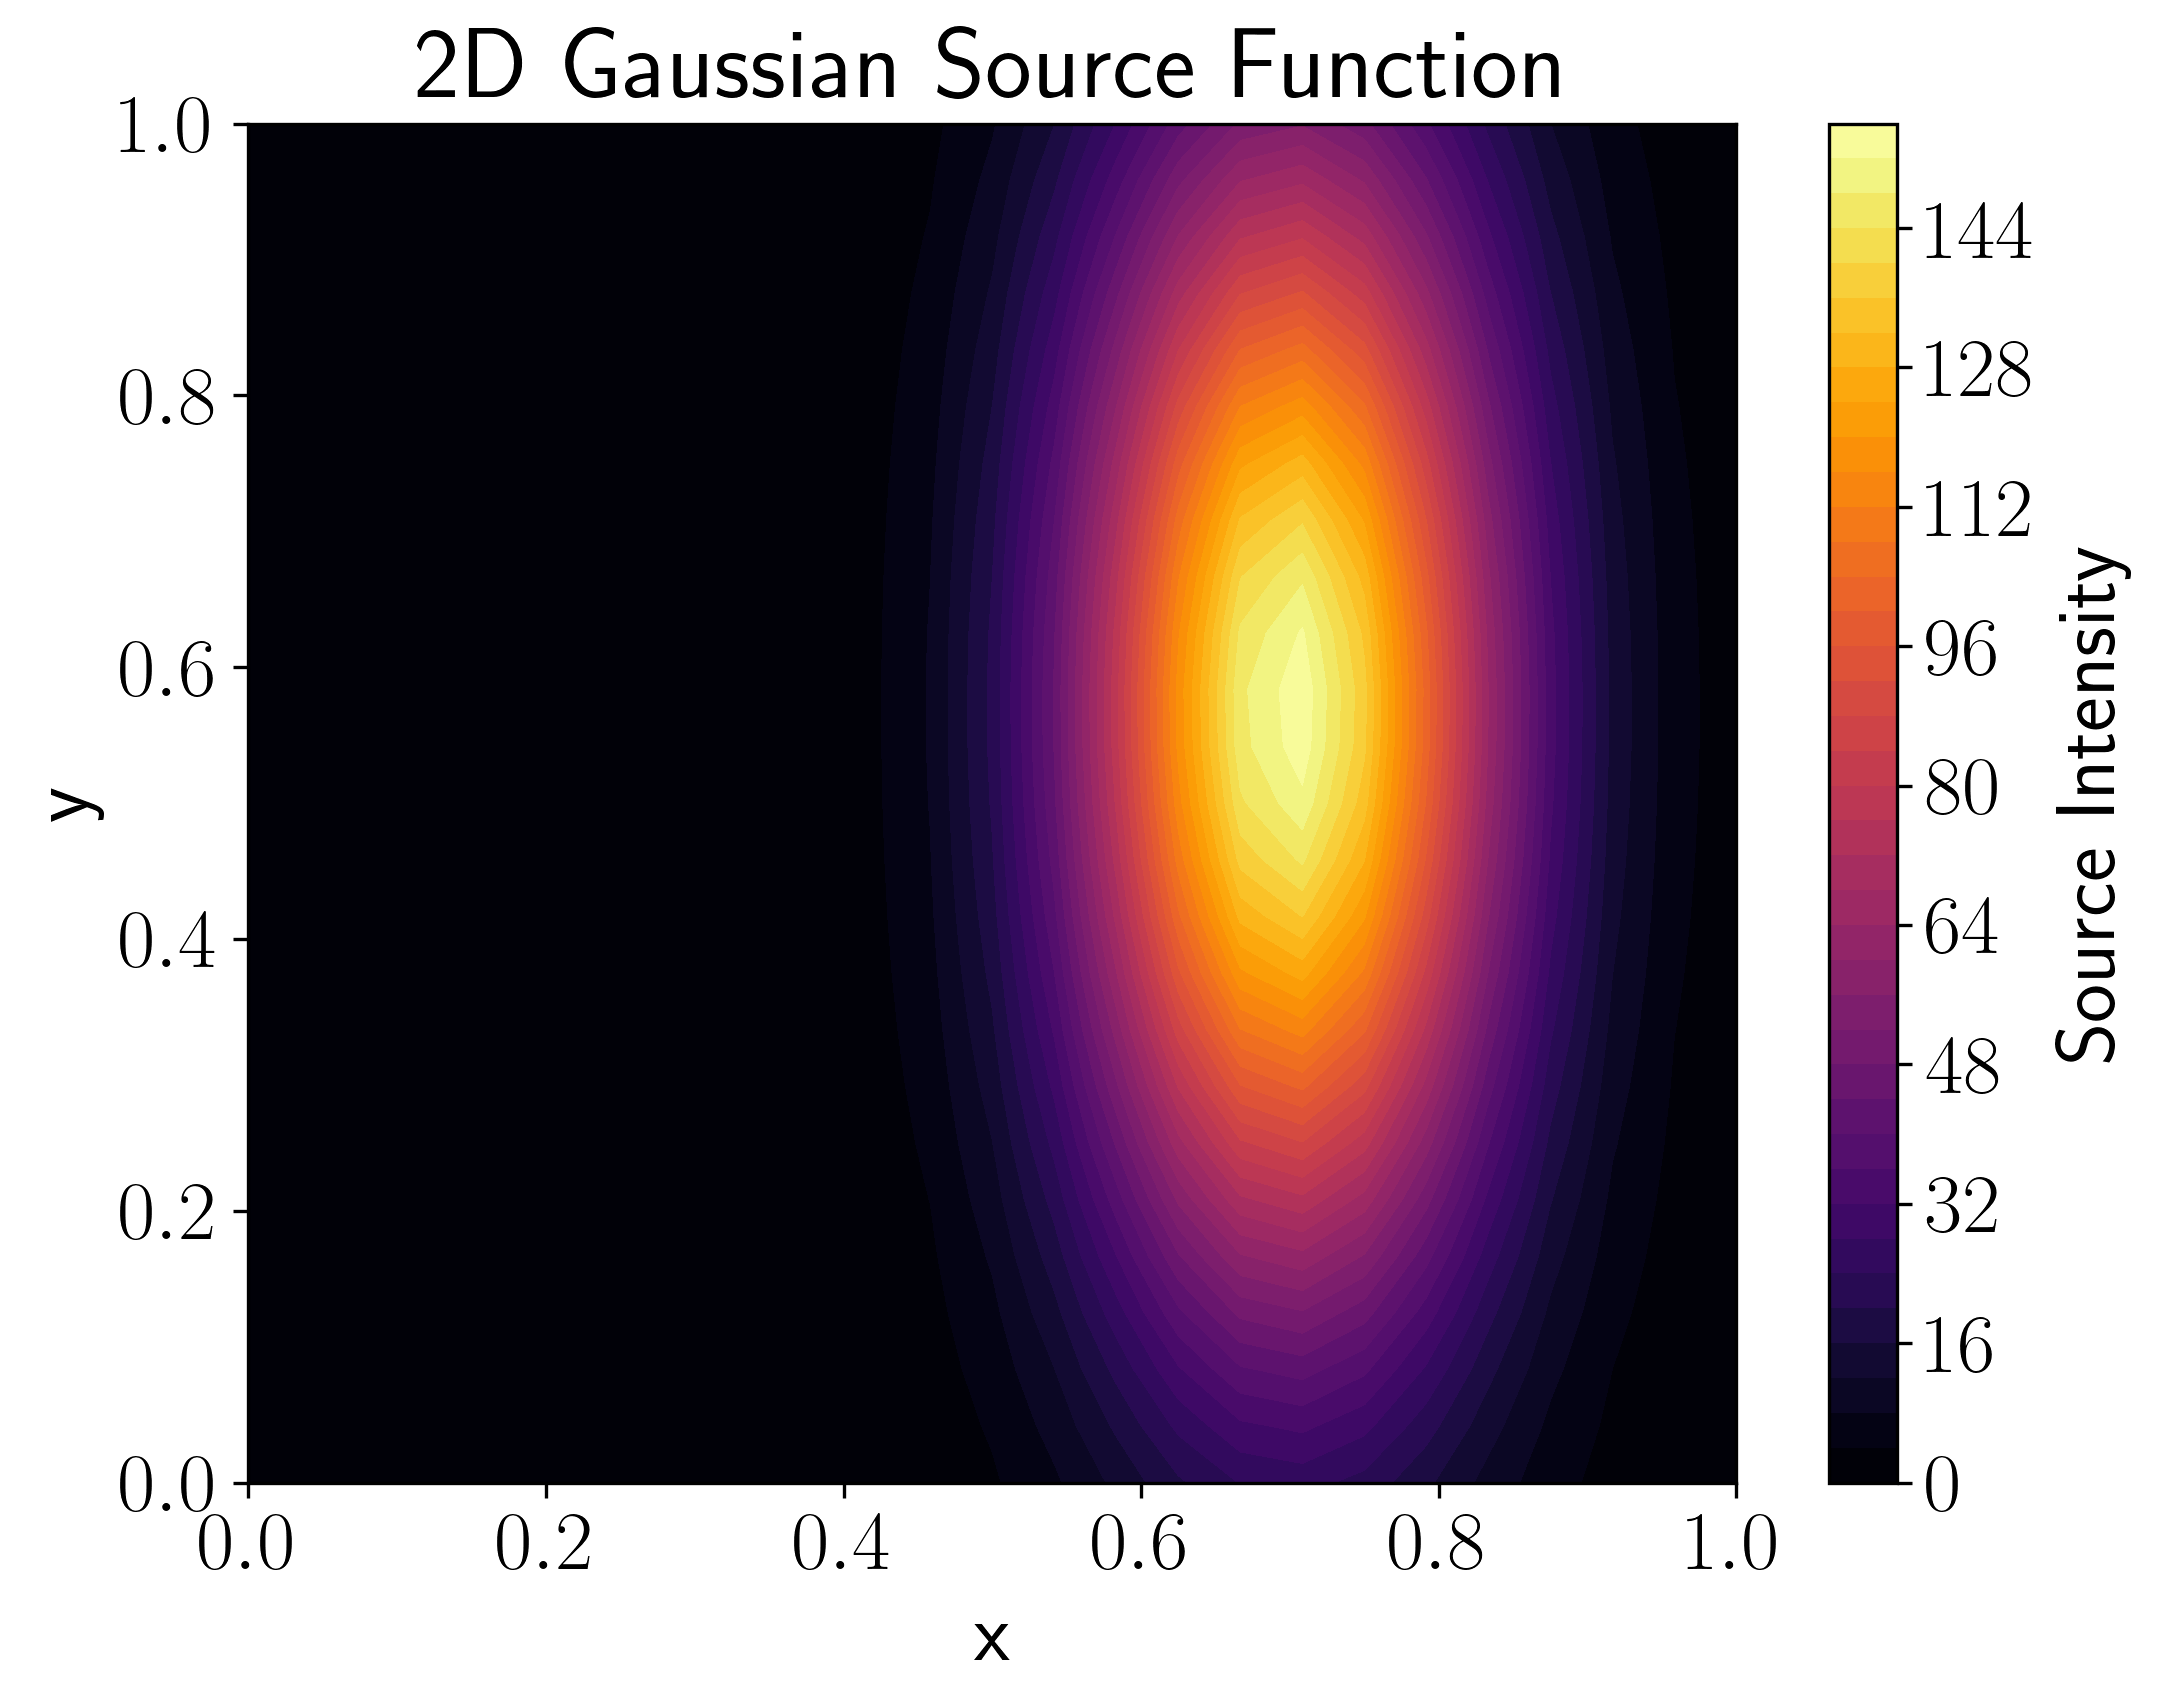

In [ ]:
def plot_source_function(source_term, x, y):
    X, Y = np.meshgrid(x, y)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(X, Y, source_term, 50, cmap='inferno') 
    plt.colorbar(label='Source Intensity') 
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('2D Gaussian Source Function')
    plt.show()

key = jax.random.PRNGKey(11)
num_gaussians = 1 
mag_scale = 100  
x = np.linspace(0, 1, 25) 
y = np.linspace(0, 1, 25) 

# Generate the 2D source function
source_term_2d = gaussian_intensity(key, mag_scale, x, y)

plot_source_function(source_term_2d, x, y)

In [27]:
# Bilinear interpolation function: because scipy griddata is not compatible with JAX vmap

def bilinear_interpolate(X, Y, Z, x, y):

    # Find the indices of the four surrounding points
    x0 = np.searchsorted(X[0, :], x) - 1
    x1 = x0 + 1
    y0 = np.searchsorted(Y[:, 0], y) - 1
    y1 = y0 + 1

    # Clip indices to stay within bounds
    x0 = np.clip(x0, 0, X.shape[1] - 1)
    x1 = np.clip(x1, 0, X.shape[1] - 1)
    y0 = np.clip(y0, 0, Y.shape[0] - 1)
    y1 = np.clip(y1, 0, Y.shape[0] - 1)

    # Fetch values from the Z matrix
    Q11 = Z[y0, x0]
    Q21 = Z[y0, x1]
    Q12 = Z[y1, x0]
    Q22 = Z[y1, x1]

    # Get the distances between the actual point and the grid points
    x0_val, x1_val = X[0, x0], X[0, x1]
    y0_val, y1_val = Y[y0, 0], Y[y1, 0]

    # Perform bilinear interpolation
    R1 = (x1_val - x) / (x1_val - x0_val) * Q11 + (x - x0_val) / (x1_val - x0_val) * Q21
    R2 = (x1_val - x) / (x1_val - x0_val) * Q12 + (x - x0_val) / (x1_val - x0_val) * Q22
    return (y1_val - y) / (y1_val - y0_val) * R1 + (y - y0_val) / (y1_val - y0_val) * R2


Ground truth solver

In [28]:
# ADI solver for 2D transient bioheat (BHT) equation. 
# Fixed temperature BC on all 4 walls

def solve_ADI_2D(key, Nx, Ny, Nt, P, mag_scale, length_scale, on_off):

    k = 0.527
    rho = 1.04e-6
    cp = 3.65e6
    rho_b = 1.06e-6
    cb = 3.6e6
    wb = 8.5e-3
    T_a = 36.7 
    qm = 9.7e-3


    # key = random.PRNGKey(70)
    subkeys = random.split(key, 4)

    # Parameters
    Lx = 1.0  # Length of the domain in the x-direction
    Ly = 1.0  # Length of the domain in the y-direction
    T = 1.0   # Total time
    alpha = k/(rho*cp)  # Thermal diffusivity

    # alpha = 0.01

    xmin, xmax = 0, 1
    ymin, ymax = 0, 1
    x = np.linspace(xmin, xmax, Nx)
    y = np.linspace(ymin, ymax, Ny)
    t = np.linspace(0, 1, Nt)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    dt = t[1] - t[0]

    T_init = 37
    T_bc_left = 37
    T_bc_right = 37
    T_bc_top = 25
    T_bc_bottom = 37

    # Initial conditions
    u0 = np.ones((Nx, Ny))*T_init

    def generate_2d_source_function(subkeys, x, y, length_scale):
        # Set up parameters
        jitter = 1e-5
        gp_params = (1, length_scale)  # GP parameters (output scale, length scale)

        # Generate grid points
        X, Y = np.meshgrid(x, y)
        grid_points = np.column_stack([X.ravel(), Y.ravel()])

        # Generate GP sample
        N = grid_points.shape[0]
        K = RBF(grid_points, grid_points, gp_params)
        L = np.linalg.cholesky(K + jitter * np.eye(N))
        gp_sample = np.dot(L, random.normal(subkeys[0], (N,)))
        gp_sample_reshaped = gp_sample.reshape(X.shape)

        # Create interpolation function
        def f_fn(x, y):
            # Flatten input for griddata
            points = np.column_stack([x.ravel(), y.ravel()])
            return bilinear_interpolate(X, Y, gp_sample_reshaped, x, y)

            # interpolated_values = interpax.interp2d(points[:,0], points[:,1], grid_points[:,0], grid_points[:,1], gp_sample, method='linear')
            # return interpolated_values.reshape(x.shape)

        return f_fn

    

    # Generate 2D source function (not time dependent)
    f_fn = generate_2d_source_function(subkeys, x, y, length_scale)

    # Generate grid for visualization
    X, Y = np.meshgrid(x, y) 

    # Evaluate the source function on the grid
    num_curves = 1
    f = np.abs(f_fn(X, Y)) + source2d(num_curves, subkeys[2], mag_scale, x, y) # default

    # f = np.abs(f_fn(X, Y)) + mc_data_power # for imported and processed MC data

    f = f.at[0,:].set(f[1,:]) # this is because the interpolation function is spitting out NaNs along two edges
    f = f.at[:,0].set(f[:,1]) 
    f = f.T

    ## laser heating source term addition with f needs to come here once you have the 2D function ready


    # ADI method with time data saving
    def ADI(u0, Nx, Ny, dx, dy, dt, alpha, Nt, T_bc_top, T_bc_bottom, T_bc_left, T_bc_right):
        u = np.copy(u0)
        # save_interval = Nt // Nx
        # temperature_evolution = np.zeros((Nx, Ny, Nx))  # Array to store temperature at each time step
        temperature_evolution = np.zeros((Nx, Ny, Nt))
        temperature_evolution = temperature_evolution.at[:,:,0].set(u0)

        Ax = alpha * dt / dx**2
        Ay = alpha * dt / dy**2

        a = -Ax / 2
        b = 1 + Ax
        c = -Ax / 2
        d = np.zeros(Nx)
        
        lower = np.zeros_like(d)
        lower = lower.at[1:-1].set(a)
        upper = np.zeros_like(d)
        upper = upper.at[1:-1].set(c)
        main = np.ones_like(d)
        main = main.at[1:-1].set(b)

        # save_count = 1

        # ADI loop
        for n in range(1, Nt):
            # X direction sweep
            for j in range(1, Ny - 1):
                
                d = d.at[1:-1].set((Ay / 2) * u[:-2, j] + (1 - Ay - (rho_b*cb*wb*dt)/(rho*cp)) * u[1:-1, j] + (Ay / 2) * u[2:, j] + dt * ((rho_b*cb*wb*T_a)/(rho*cp)) + dt * ((qm)/(rho*cp)) + dt * ((f[1:-1,j])/(rho*cp))) 
                d = d.at[0].set((Ay / 2) * u[0, j] + (1 - Ay - (rho_b*cb*wb*dt)/(rho*cp)) * u[1, j] + (Ay / 2) * u[2, j] + dt * ((rho_b*cb*wb*T_a)/(rho*cp)) + dt * ((qm)/(rho*cp)) + dt * ((f[0,j])/(rho*cp))) 
                d = d.at[-1].set((Ay / 2) * u[-1, j] + (1 - Ay - (rho_b*cb*wb*dt)/(rho*cp)) * u[-2, j] + (Ay / 2) * u[-3, j] + dt * ((rho_b*cb*wb*T_a)/(rho*cp)) + dt * ((qm)/(rho*cp)) + dt * ((f[-1,j])/(rho*cp)))
                # u = u.at[:,j].set(np.linalg.solve(np.diag(a * np.ones(Nx - 1), -1) + np.diag(b * np.ones(Nx), 0) + np.diag(c * np.ones(Nx - 1), 1), d))
                u_updated = jax.lax.linalg.tridiagonal_solve(lower, main, upper, np.expand_dims(d,1))
                u = u.at[:,j].set(u_updated.squeeze())
                # u = u.at[:,-1].set(T_bc_top)
                # u = u.at[:,0].set(T_bc_bottom)
                u = u.at[0,:].set(T_bc_left)
                u = u.at[-1,:].set(T_bc_right)

            # Y direction sweep
            for i in range(1, Nx - 1):

                d = d.at[1:-1].set((Ax / 2) * u[i, :-2] + (1 - Ax - (rho_b*cb*wb*dt)/(rho*cp)) * u[i, 1:-1] + (Ax / 2) * u[i, 2:] + dt * ((rho_b*cb*wb*T_a)/(rho*cp)) + dt * ((qm)/(rho*cp)) + dt * ((f[i,1:-1])/(rho*cp))) 
                d = d.at[0].set((Ax / 2) * u[i, 0] + (1 - Ax - (rho_b*cb*wb*dt)/(rho*cp)) * u[i, 1] + (Ax / 2) * u[i, 2] + dt * ((rho_b*cb*wb*T_a)/(rho*cp)) + dt * ((qm)/(rho*cp)) + dt * ((f[i,0])/(rho*cp)))
                d = d.at[-1].set((Ax / 2) * u[i, -1] + (1 - Ax - (rho_b*cb*wb*dt)/(rho*cp)) * u[i, -2] + (Ax / 2) * u[i, -3] + dt * ((rho_b*cb*wb*T_a)/(rho*cp)) + dt * ((qm)/(rho*cp)) + dt * ((f[i,-1])/(rho*cp)))
                # u = u.at[i,:].set(np.linalg.solve(np.diag(a * np.ones(Ny - 1), -1) + np.diag(b * np.ones(Ny), 0) + np.diag(c * np.ones(Ny - 1), 1), d)) 
                u_updated = jax.lax.linalg.tridiagonal_solve(lower, main, upper, np.expand_dims(d,1))
                u = u.at[:,j].set(u_updated.squeeze())
                u = u.at[:,-1].set(T_bc_top)
                u = u.at[:,0].set(T_bc_bottom)
                # u = u.at[0,:].set(T_bc_left)
                # u = u.at[-1,:].set(T_bc_right)

            temperature_evolution = temperature_evolution.at[:,:,n].set(u)

            # if n % save_interval == 0 and save_count < Nx:
            #     temperature_evolution = temperature_evolution.at[:,:,save_count].set(u)
            #     save_count += 1

        return u, temperature_evolution

    # Solve using ADI with time data saving
    u_final, u = ADI(u0, Nx, Ny, dx, dy, dt, alpha, Nt, T_bc_top, T_bc_bottom, T_bc_left, T_bc_right)

    UU = u

    u = f

    idx_xy = random.randint(subkeys[1], (P,2), 0, max(Nx,Ny))
    idx_t = random.randint(subkeys[3], (P,1), 0, Nt)
    idx = np.hstack((idx_xy, idx_t))
    y_ = np.concatenate([x[idx[:,0]][:,None], y[idx[:,1]][:,None], t[idx[:,2]][:,None]], axis = 1)
    s = UU[idx[:,0], idx[:,1], idx[:,2]]

    # # Plot the solution
    # X, Y = np.meshgrid(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny))
    # plt.figure(figsize=(10, 6))
    # plt.pcolormesh(X, Y, u_final.T, shading='auto', cmap='jet')
    # plt.colorbar(label='Temperature')
    # plt.xlabel('X')
    # plt.ylabel('Y')
    # plt.title('2D Heat Diffusion using ADI')
    # plt.show()

    # # Plot the temperature evolution
    # plt.figure(figsize=(10, 6))
    # for n in range(0, Nt + 1, 10):  # Plot every 10th time step
    #     plt.pcolormesh(X, Y, temperature_evolution[:, :, n].T, shading='auto', cmap='jet')
    #     plt.colorbar(label='Temperature')
    #     plt.xlabel('X')
    #     plt.ylabel('Y')
    #     plt.title(f'Time = {n * dt}')
    #     plt.show()

    return (x, y, t, UU), (u, y_, s)


In [ ]:
# ----------------------------
# ADI solver with Robin BC on top (rest Dirichlet = 37°C)
# ----------------------------
def solve_ADI_2D(key, Nx, Ny, Nt, P, mag_scale, length_scale, on_off):

    k = 0.527
    rho = 1.04e-6
    cp = 3.65e6
    rho_b = 1.06e-6
    cb = 3.6e6
    wb = 8.5e-3
    T_a = 36.7 
    qm = 9.7e-3

    # Convective coefficient for Robin (top)
    h_top_conv = 5000.0   # [W/(m^2 K)] 
    T_inf = 25.0        # ambient temperature for convection (same units as T)

    subkeys = random.split(key, 4)

    # Parameters
    Lx = 1.0  # Length of the domain in the x-direction
    Ly = 1.0  # Length of the domain in the y-direction
    T = 1.0   # Total time
    alpha = k/(rho*cp)  # Thermal diffusivity

    xmin, xmax = 0, 1
    ymin, ymax = 0, 1
    x = np.linspace(xmin, xmax, Nx)
    y = np.linspace(ymin, ymax, Ny)
    t = np.linspace(0, 1, Nt)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    dt = t[1] - t[0]

    T_init = 37.0
    T_bc_left = 37.0
    T_bc_right = 37.0
    T_bc_top_dirichlet = 25.0   # unused now as top is Robin, kept for clarity
    T_bc_bottom = 37.0

    # Initial conditions
    u0 = np.ones((Nx, Ny))*T_init

    def generate_2d_source_function(subkeys, x, y, length_scale):
        # Set up parameters
        jitter = 1e-5
        gp_params = (1, length_scale)  # GP parameters (output scale, length scale)

        # Generate grid points
        X, Y = np.meshgrid(x, y)
        grid_points = np.column_stack([X.ravel(), Y.ravel()])

        # Generate GP sample
        N = grid_points.shape[0]
        K = RBF(grid_points, grid_points, gp_params)
        L = np.linalg.cholesky(K + jitter * np.eye(N))
        gp_sample = np.dot(L, random.normal(subkeys[0], (N,)))
        gp_sample_reshaped = gp_sample.reshape(X.shape)

        # Create interpolation function
        def f_fn(xq, yq):
            # Flatten input for griddata
            points = np.column_stack([xq.ravel(), yq.ravel()])
            return bilinear_interpolate(X, Y, gp_sample_reshaped, xq, yq)

        return f_fn

    # Generate 2D source function (not time dependent)
    f_fn = generate_2d_source_function(subkeys, x, y, length_scale)

    # Generate grid for visualization
    X, Y = np.meshgrid(x, y) 

    # Evaluate the source function on the grid
    num_curves = 1
    f = np.abs(f_fn(X, Y)) + source2d(num_curves, subkeys[2], mag_scale, x, y) # default

    f = f.at[0,:].set(f[1,:]) # fix NaNs along edges if present
    f = f.at[:,0].set(f[:,1]) 
    f = f.T

    # ADI method with time data saving
    def ADI(u0, Nx, Ny, dx, dy, dt, alpha, Nt, T_inf, T_bc_bottom, T_bc_left, T_bc_right):
        u = np.copy(u0)
        temperature_evolution = np.zeros((Nx, Ny, Nt))
        temperature_evolution = temperature_evolution.at[:,:,0].set(u0)

        Ax = alpha * dt / dx**2
        Ay = alpha * dt / dy**2

        # Coefficients for tri-diagonal (X-direction base)
        a = -Ax / 2.0
        b = 1.0 + Ax
        c = -Ax / 2.0
        d = np.zeros(Nx, dtype=np.float32)
        
        lower = np.zeros_like(d)
        lower = lower.at[1:-1].set(a)
        upper = np.zeros_like(d)
        upper = upper.at[1:-1].set(c)
        main = np.ones_like(d)
        main = main.at[1:-1].set(b)

        # ADI loop
        for n in range(1, Nt):
            # X direction sweep (implicit in x)
            for j in range(1, Ny - 1):
                # RHS vector d for x-sweep (column j)
                d = d.at[1:-1].set(
                    (Ay / 2.0) * u[:-2, j]
                    + (1.0 - Ay - (rho_b*cb*wb*dt)/(rho*cp)) * u[1:-1, j]
                    + (Ay / 2.0) * u[2:, j]
                    + dt * ((rho_b*cb*wb*T_a)/(rho*cp))
                    + dt * (qm/(rho*cp))
                    + dt * (f[1:-1, j]/(rho*cp))
                )
                d = d.at[0].set(
                    (Ay / 2.0) * u[0, j]
                    + (1.0 - Ay - (rho_b*cb*wb*dt)/(rho*cp)) * u[1, j]
                    + (Ay / 2.0) * u[2, j]
                    + dt * ((rho_b*cb*wb*T_a)/(rho*cp))
                    + dt * (qm/(rho*cp))
                    + dt * (f[0, j]/(rho*cp))
                )
                d = d.at[-1].set(
                    (Ay / 2.0) * u[-1, j]
                    + (1.0 - Ay - (rho_b*cb*wb*dt)/(rho*cp)) * u[-2, j]
                    + (Ay / 2.0) * u[-3, j]
                    + dt * ((rho_b*cb*wb*T_a)/(rho*cp))
                    + dt * (qm/(rho*cp))
                    + dt * (f[-1, j]/(rho*cp))
                )
                # solve tridiagonal for column j
                u_updated = jax.lax.linalg.tridiagonal_solve(lower, main, upper, np.expand_dims(d,1))
                u = u.at[:, j].set(u_updated.squeeze())

                # enforce Dirichlet left & right boundaries for entire row after update
                u = u.at[0,:].set(T_bc_left)
                u = u.at[-1,:].set(T_bc_right)

            # Y direction sweep (implicit in y)
            for i in range(1, Nx - 1):
                # build RHS d for row i (y-direction)
                d = d.at[1:-1].set(
                    (Ax / 2.0) * u[i, :-2]
                    + (1.0 - Ax - (rho_b*cb*wb*dt)/(rho*cp)) * u[i, 1:-1]
                    + (Ax / 2.0) * u[i, 2:]
                    + dt * ((rho_b*cb*wb*T_a)/(rho*cp))
                    + dt * (qm/(rho*cp))
                    + dt * (f[i, 1:-1]/(rho*cp))
                )
                d = d.at[0].set(
                    (Ax / 2.0) * u[i, 0]
                    + (1.0 - Ax - (rho_b*cb*wb*dt)/(rho*cp)) * u[i, 1]
                    + (Ax / 2.0) * u[i, 2]
                    + dt * ((rho_b*cb*wb*T_a)/(rho*cp))
                    + dt * (qm/(rho*cp))
                    + dt * (f[i, 0]/(rho*cp))
                )
                # previously this was set using u[i,-1] terms (Dirichlet). For Robin we still set a RHS
                d = d.at[-1].set(
                    (Ax / 2.0) * u[i, -1]
                    + (1.0 - Ax - (rho_b*cb*wb*dt)/(rho*cp)) * u[i, -2]
                    + (Ax / 2.0) * u[i, -3]
                    + dt * ((rho_b*cb*wb*T_a)/(rho*cp))
                    + dt * (qm/(rho*cp))
                    + dt * (f[i, -1]/(rho*cp))
                )

                # Solve tridiagonal for row i. NOTE: we intentionally solve the full row,
                # then overwrite the top node with the Robin relation to enforce convective BC.
                u_updated = jax.lax.linalg.tridiagonal_solve(lower, main, upper, np.expand_dims(d,1))
              
                u = u.at[i, :].set(u_updated.squeeze())

                u = u.at[:, 0].set(T_bc_bottom)

                denom = 1.0 + (h_top_conv * dy) / k
                T_top_from_robin = (u[i, -2] + (h_top_conv * dy / k) * T_inf) / denom
                u = u.at[i, -1].set(T_top_from_robin)

            temperature_evolution = temperature_evolution.at[:,:,n].set(u)

        return u, temperature_evolution

    # Solve using ADI with time data saving
    u_final, u = ADI(u0, Nx, Ny, dx, dy, dt, alpha, Nt, T_inf, T_bc_bottom, T_bc_left, T_bc_right)

    UU = u

    u = f

    idx_xy = random.randint(subkeys[1], (P,2), 0, max(Nx,Ny))
    idx_t = random.randint(subkeys[3], (P,1), 0, Nt)
    idx = np.hstack((idx_xy, idx_t))
    y_ = np.concatenate([x[idx[:,0]][:,None], y[idx[:,1]][:,None], t[idx[:,2]][:,None]], axis = 1)
    s = UU[idx[:,0], idx[:,1], idx[:,2]]

    return (x, y, t, UU), (u, y_, s)


Training data generation functions

In [7]:
# Geneate training data corresponding to one input sample
def generate_one_training_data(key, P):
    # Numerical solution
    (x, y, t, UU), (u, y_, s) = solve_ADI_2D(key, Nx, Ny, Nt, P, mag_scale=100, length_scale=0.2, on_off=1)

    u_train = np.tile(u, (P, 1)) 
    # s_ = s 

    return u_train, y_, s

# Geneate training data corresponding to N input sample
def generate_training_data(key, N, P):
    # config.update("jax_enable_x64", True)
    keys = random.split(key, N)
    u_train, y_train, s_train = vmap(generate_one_training_data, (0, None))(keys, P)

    u_train = np.float32(u_train.reshape(N * P, -1))
    y_train = np.float32(y_train.reshape(N * P, -1))
    s_train = np.float32(s_train.reshape(N * P, -1))

    u_min = u_train.min()
    u_max = u_train.max()
    # s_min = s_train.min()
    # s_max = s_train.max()

    u_train_scaled = (u_train - u_min) / (u_max - u_min) 
    # s_train_scaled = (s_train - s_min) / (s_max - s_min)


    # u_train_scaled = scaler_u.fit_transform(u_train)
    # y_train_scaled = scaler_y.fit_transform(y_train)
    # s_train_scaled = scaler_s.fit_transform(s_train)


    # config.update("jax_enable_x64", False)
    return u_train_scaled, y_train, s_train, u_min, u_max

Testing data generation functions

In [22]:
# Geneate test data corresponding to one input sample
def generate_one_test_data_groundtruth(key, Px, Pt):
    Nx = Px
    Ny = Px
    Nt = Pt
    (x, y, t, UU), (u, y_, s) = solve_ADI_2D(key, Nx, Ny, Nt, Px, mag_scale=100, length_scale=0.2, on_off=1)

    XX, YY, TT = np.meshgrid(x, y, t)

    u_test = np.tile(u, (Nx*Ny*Nt, 1))
    y_test = np.hstack([XX.flatten()[:,None], YY.flatten()[:,None], TT.flatten()[:,None]])
    s_test = np.transpose(UU, (1,0,2)).flatten()

    return u_test, y_test, s_test

# Geneate test data corresponding to N input sample
def generate_test_data_groundtruth(key, N, Px, Pt, u_min, u_max):

    config.update("jax_enable_x64", False)
    keys = random.split(key, N)

    u_test, y_test, s_test = vmap(generate_one_test_data_groundtruth, (0, None, None))(keys, Px, Pt)

    u_test = np.float32(u_test.reshape(N * Px*Px*Pt, -1))
    y_test = np.float32(y_test.reshape(N * Px*Px*Pt, -1))
    s_test = np.float32(s_test.reshape(N * Px*Px*Pt, -1))

    u_test_scaled = (u_test - u_min) / (u_max - u_min)
    # s_test_scaled = (s_test - s_min) / (s_max - s_min)
    # u_test_scaled = scaler_u.fit_transform(u_test)
    # y_test_scaled = scaler_y.transform(y_test)
    # s_test_scaled = scaler_s.transform(s_test)

    return u_test_scaled, y_test, s_test

Generate training data

In [6]:
key = random.PRNGKey(47)

# GRF length scale
length_scale = 0.2
mag_scale = 100

# Resolution of the solution
Nx = 25
Ny = Nx
Nt = 125

N = 2000 # number of input samples
m = Nx   # number of input sensors
P_train = 2500 # number of output sensors
# Q_train = 100
# u_train, y_train, s_train = generate_training_data(key, N, P_train, Q_train)

In [9]:
config.update("jax_enable_x64", False)
with jax.default_device(jax.devices("cpu")[0]):
    u_train, y_train, s_train, u_min, u_max = generate_training_data(key, N, P_train)

In [ ]:
u_train_out = "Paper data/Updated source term/Generalization studies/u_train_25_2500_mag100_ls0.2.npy"
y_train_out = "Paper data/Updated source term/Generalization studies/y_train_25_2500_mag100_ls0.2.npy"
s_train_out = "Paper data/Updated source term/Generalization studies/s_train_25_2500_mag100_ls0.2.npy"
u_min_out = "Paper data/Updated source term/Generalization studies/u_min_25_2500_mag100_ls0.2.npy"
u_max_out = "Paper data/Updated source term/Generalization studies/u_max_25_2500_mag100_ls0.2.npy"
np.save(u_train_out, u_train)
np.save(y_train_out, y_train)
np.save(s_train_out, s_train)
np.save(u_min_out, u_min)
np.save(u_max_out, u_max)

In [6]:
u_train = numpy.load('Paper data/Updated source term/Generalization studies/u_train_25_2500_mag100_ls0.2.npy', mmap_mode='r')
y_train = numpy.load('Paper data/Updated source term/Generalization studies/y_train_25_2500_mag100_ls0.2.npy', mmap_mode='r')
s_train = numpy.load('Paper data/Updated source term/Generalization studies/s_train_25_2500_mag100_ls0.2.npy', mmap_mode='r')

In [ ]:
u_min = numpy.load('Paper data/Updated source term/Generalization studies/u_min_25_2500_mag100_ls0.2.npy', mmap_mode='r')
u_max = numpy.load('Paper data/Updated source term/Generalization studies/u_max_25_2500_mag100_ls0.2.npy', mmap_mode='r')

In [20]:
jax.clear_backends()

In [ ]:
u_train = jax.device_put(u_train, jax.devices("cpu")[0])
y_train = jax.device_put(y_train, jax.devices("cpu")[0])
s_train = jax.device_put(s_train, jax.devices("cpu")[0])

In [21]:
u_min = jax.device_put(u_min, jax.devices("cpu")[0])
u_max = jax.device_put(u_max, jax.devices("cpu")[0])

Data generator class

In [ ]:
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s,
                 batch_size, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u 
        self.y = y 
        self.s = s 

        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    # @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)

        u_batch = jax.device_put(self.u[idx, :])
        y_batch = jax.device_put(self.y[idx, :])
        s_batch = jax.device_put(self.s[idx, :]) 

        # Construct batch
        inputs = (u_batch, y_batch)
        outputs = s_batch
        return inputs, outputs

Vanilla DeepONet class

In [5]:
# Define the model - Vanilla DeepONet
class DeepONet:
    def __init__(self, branch_layers, trunk_layers):    
        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = MLP(branch_layers, activation=np.tanh)  # or Relu 
        self.trunk_init, self.trunk_apply = MLP(trunk_layers, activation=np.tanh)     # or Relu

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-4, 
                                                                      decay_steps=1000, 
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)

        self.itercount = itertools.count()

        # Loggers
        self.loss_log = []

    # Define DeepONet architecture
    def operator_net(self, params, u, space_x, space_y, t):
        branch_params, trunk_params = params
        y = np.stack([space_x, space_y, t])
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        outputs = np.sum(B * T)
        return  outputs
  
    # Define operator loss
    def loss_operator(self, params, batch):
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        s_pred = vmap(self.operator_net, (None, 0, 0, 0, 0))(params, u, y[:,0], y[:,1], y[:,2])
        # Compute loss
        loss = np.mean((outputs.flatten() - s_pred.flatten())**2)
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        g = grad(self.loss_operator)(params, batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, dataset, nIter = 10000):
        # Define data iterators
        data_iterator = iter(dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Fetch data
            batch = next(data_iterator)
           
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
            
            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute loss
                loss_value = self.loss_operator(params, batch)

                # Store loss
                self.loss_log.append(loss_value)
  
                # Print loss
                pbar.set_postfix({'Loss': loss_value})
           
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1], Y_star[:,2])
        return s_pred
  

ResFouriONet class

In [4]:
# Define the model -- ResFouriONet
class ResFouriONet:
    def __init__(self, branch_in_features, trunk_in_features, out_features, num_projection, nlayers):  
        # Network initialization and evaluation functions
        self.branch_params = BHTDNN.init(branch_in_features, out_features, num_projection, nlayers, key=1234)
        self.trunk_params = BHTsDNN.init(trunk_in_features, out_features, num_projection, key=4321)
        params = (self.branch_params, self.trunk_params)

        def optimizer_fn(init_lr, decay_steps, decay_rate):
            # out = optimizers.adam(optimizers.exponential_decay(init_lr, decay_steps, decay_rate))
            out = complex_adam(optimizers.exponential_decay(init_lr, decay_steps, decay_rate))
            opt_init, opt_update, get_params = out
            return opt_init, opt_update, get_params
        
        self.opt_init, self.opt_update, self.get_params = optimizer_fn(init_lr=1e-4, decay_steps=1000, decay_rate=0.9)

        # self.opt_init, self.opt_update, self.get_params = optimizers.adam(1e-3)
        
        self.opt_state = self.opt_init(params)

        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)

        self.itercount = itertools.count()

        # Loggers
        self.loss_log = []

    # Define DeepONet architecture
    def operator_net(self, params, source, space_x, space_y, time):
        branch_params = params[0]
        trunk_params = params[1]
        x = np.stack([space_x, space_y, time])
        B = BHTDNN.apply(branch_params, source)
        T = BHTsDNN.apply(trunk_params, x)
        return np.sum(B*T)
  
    # Define a loss functionmax_grad_norm
    def loss_function(self, val_true, val_predicted):
        loss = optax.l2_loss(val_predicted, val_true).mean() # MSE loss
        return loss
    
    # Define boundary loss
    def loss(self, params, batch):
        inputs, outputs = batch
        u, y = inputs
        # print(f'u dim = {u.shape}, y_dim = {y.shape}')

        # Compute forward pass
        s_pred = vmap(self.operator_net, (None, 0, 0, 0, 0))(params, u, y[:,0], y[:,1], y[:,2])

        # Compute loss
        loss = self.loss_function(outputs.flatten(), s_pred)
        return loss
    
    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, batch)
        g = optimizers.clip_grads(g, 0.4)
        return self.opt_update(i, g, opt_state)

    # @partial(jit, static_argnums=(0,))
    # Optimize parameters in a loop
    def train(self, dataset, nIter = 10000):
        # Define data iterators
        data_iterator = iter(dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Fetch data
            batch = next(data_iterator)
           
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
            
            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute loss
                loss_value = self.loss(params, batch)

                # Store loss
                self.loss_log.append(loss_value)
  
                # Print loss
                pbar.set_postfix({'Loss': loss_value})
           
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1], Y_star[:,2])
        return s_pred

FNO implementation (DeepONet-like class)

In [ ]:
import jax
from jax import random, grad, jit, vmap
import jax.numpy as np
from jax.example_libraries import optimizers
from functools import partial
import itertools
from tqdm import trange
from jax.flatten_util import ravel_pytree


def make_grid(H, W):
    xs = np.linspace(0.0, 1.0, W, dtype=np.float32)
    ys = np.linspace(0.0, 1.0, H, dtype=np.float32)
    X, Y = np.meshgrid(xs, ys, indexing='xy')
    return np.stack([X, Y], axis=-1)  # (H, W, 2)


def bilinear_sample(grid, x, y):
    """
    grid: (H, W) temperature field (jax array)
    x, y: scalars in [0,1] (x horizontal coord, y vertical coord)
    returns scalar (interpolated)
    """
    H, W = grid.shape
    fx = x * (W - 1)
    fy = y * (H - 1)

    # integer indices for indexing
    x0 = np.clip(np.floor(fx).astype(np.int32), 0, W - 1)
    y0 = np.clip(np.floor(fy).astype(np.int32), 0, H - 1)
    x1 = np.clip(x0 + 1, 0, W - 1)
    y1 = np.clip(y0 + 1, 0, H - 1)

    # fractional weights (float)
    wx = fx - x0.astype(np.float32)
    wy = fy - y0.astype(np.float32)

    Ia = grid[y0, x0]
    Ib = grid[y0, x1]
    Ic = grid[y1, x0]
    Id = grid[y1, x1]

    wa = (1.0 - wx) * (1.0 - wy)
    wb = wx * (1.0 - wy)
    wc = (1.0 - wx) * wy
    wd = wx * wy
    return wa * Ia + wb * Ib + wc * Ic + wd * Id


def init_spectral_params(key, in_ch, out_ch, mx, my, scale=0.02):
    k1, k2 = random.split(key)
    shape = (in_ch, out_ch, mx, my)
    w_re = scale * random.normal(k1, shape, dtype=np.float32)
    w_im = scale * random.normal(k2, shape, dtype=np.float32)
    return {'w_re': w_re, 'w_im': w_im}


def spectral_conv2d_apply(params, x, mx, my):
    """
    x: (H, W, Cin)  (no batch here)
    mx,my: Python ints (modes), pass from self.modes so they are static
    returns: (H, W, Cout) real
    """
    H = x.shape[0]
    W = x.shape[1]
    # FFT over spatial dims (H, W)
    x_ft = np.fft.rfftn(x, s=(H, W), axes=(0, 1)) 

    Hm = min(mx, H)
    Wm = min(my, x_ft.shape[1])

    x_low = x_ft[:Hm, :Wm, :]                 
    w = params['w_re'] + 1j * params['w_im']    
    w = w[:, :, :Hm, :Wm]                 
    x_low_t = np.transpose(x_low, (2, 0, 1))   
    out_low = np.einsum('cij,coij->oij', x_low_t, w)  
    out_low = np.transpose(out_low, (1, 2, 0))     

    out_ft = np.zeros((H, W // 2 + 1, w.shape[1]), dtype=np.complex64) 
    out_ft = out_ft.at[:Hm, :Wm, :].set(out_low)

    # inverse FFT to physical space
    out = np.fft.irfft2(out_ft, s=(H, W), axes=(0, 1))
    return out.astype(np.float32)   

def init_linear_params(key, in_ch, out_ch):
    k = key
    lim = np.sqrt(6.0 / (in_ch + out_ch))
    W = random.uniform(k, (in_ch, out_ch), minval=-lim, maxval=lim, dtype=np.float32)
    b = np.zeros((out_ch,), dtype=np.float32)
    return {'W': W, 'b': b}

def linear_apply(params, x):
    return (np.dot(x, params['W']) + params['b']).astype(np.float32)  

def init_fnoblock_params(key, width, mx, my):
    k1, k2, k3 = random.split(key, 3)
    spec = init_spectral_params(k1, width, width, mx, my)
    w1 = init_linear_params(k2, width, width)
    w2 = init_linear_params(k3, width, width)
    return {'spec': spec, 'w1': w1, 'w2': w2}


def fnoblock_apply(params, x, mx, my):
    """
    x: (H, W, C)
    mx,my: Python ints (modes)
    """
    # spectral conv expects mx,my as static ints (pass from self.modes when calling)
    s = spectral_conv2d_apply(params['spec'], x, mx, my)   
    p = linear_apply(params['w1'], x)                     
    out = np.tanh(s + p)
    out = linear_apply(params['w2'], out) + x
    return out.astype(np.float32)


def init_fno2d_params(key, in_ch, out_ch, width, n_layers, mx, my, H, W):
    """
    Returns a params dict that contains only array leaves (weights/biases/grid).
    Do NOT include H, W, mx, my as python ints in the params pytree.
    """
    keys = random.split(key, n_layers + 2)
    lift = init_linear_params(keys[0], in_ch + 1 + 2, width)  
    blocks = [init_fnoblock_params(keys[i + 1], width, mx, my) for i in range(n_layers)]
    proj = init_linear_params(keys[-1], width, out_ch)
    grid = make_grid(H, W).astype(np.float32) 

    return {'lift': lift, 'blocks': blocks, 'proj': proj, 'grid': grid}


def fno2d_apply(params, x, mx, my):
    """
    x: (H, W, C_in)
    mx,my: Python ints (modes), pass from self.modes
    returns: (H, W, C_out)
    """
    H = x.shape[0]
    W = x.shape[1]

    grid = params['grid']  
    xin = np.concatenate([x, grid], axis=-1)  
    u = linear_apply(params['lift'], xin)  
    for blk in params['blocks']:
        u = fnoblock_apply(blk, u, mx, my)
    y = linear_apply(params['proj'], u)      
    return y


class FNO_Operator:
    """
    FNO adapted to the operator interface:
      - operator_net(params, source, x, y, t) -> scalar
      - loss(params, batch) with batch format ((u, y), s)
      - train(dataset, nIter=...) and predict_s(...) as in DeepONet
    """

    def __init__(self, m, in_channels=1, out_channels=1,
                 width=64, n_layers=4, modes=(16, 16),
                 lr=1e-4, decay_steps=1000, decay_rate=0.9, key=0):
        self.m = int(m)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.width = width
        self.n_layers = n_layers

        self.modes = (int(modes[0]), int(modes[1]))
        self.H = self.W = int(m)

        key = random.PRNGKey(key)

        self.params = init_fno2d_params(key, in_channels, out_channels, width,
                                       n_layers, self.modes[0], self.modes[1],
                                       self.H, self.W)

        self.opt_init, self.opt_update, self.get_params = complex_adam(
            optimizers.exponential_decay(lr, decay_steps=decay_steps, decay_rate=decay_rate)
        )
        self.opt_state = self.opt_init(self.params)
        _, self.unravel_params = ravel_pytree(self.params)
        self.itercount = itertools.count()
        self.loss_log = []    

    @partial(jit, static_argnums=(0,))
    def operator_net(self, params, source, space_x, space_y, time):
        m = self.m
        u = source.reshape(m, m, 1).astype(np.float32)   
        tplane = np.ones((m, m, 1), dtype=np.float32) * np.asarray(time, dtype=np.float32)
        x_in = np.concatenate([u, tplane], axis=-1)    
        T_hat = fno2d_apply(params, x_in, self.modes[0], self.modes[1]).squeeze(-1)

        s_pred = bilinear_sample(T_hat, space_x.astype(np.float32), space_y.astype(np.float32))
        return s_pred

    def loss(self, params, batch):
        (u, y), s = batch
        s_pred = vmap(self.operator_net, (None, 0, 0, 0, 0))(params, u, y[:, 0], y[:, 1], y[:, 2])
        return np.mean((s_pred.reshape(-1) - s.reshape(-1)) ** 2)
    

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, batch)
        return self.opt_update(i, g, opt_state)

    def train(self, dataset, nIter=10000):
        data_iterator = iter(dataset)
        pbar = trange(nIter)
        for it in pbar:
            batch = next(data_iterator)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)

            if it % 100 == 0:
                params = self.get_params(self.opt_state)
                loss_value = self.loss(params, batch)
                self.loss_log.append(loss_value)
                pbar.set_postfix({'Loss': float(loss_value)})

    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        return vmap(self.operator_net, (None, 0, 0, 0, 0))(params, U_star, Y_star[:, 0], Y_star[:, 1], Y_star[:, 2])


Training

In [13]:
# Create data set
batch_size = 64
dataset = DataGenerator(u_train, y_train, s_train, batch_size)

In [7]:
# Nx = 25
# Ny = 25
# Nt = 125
# m = Nx
model = ResFouriONet(branch_in_features=m*m, trunk_in_features=3, out_features=128, num_projection=2048, nlayers=5)

In [16]:
jax.clear_backends()

In [15]:
model.train(dataset, nIter=20000)

 77%|███████▋  | 15318/20000 [21:14<06:29, 12.01it/s, Loss=0.08687209] 


KeyboardInterrupt: 

In [ ]:
# Initialize model
branch_layers = [m*m, 2048, 2048, 2048, 2048, 128]
trunk_layers =  [3, 2048, 2048, 2048, 2048, 128]
model = DeepONet(branch_layers, trunk_layers)

In [ ]:
# Train
model.train(dataset, nIter=100000)

100%|██████████| 20000/20000 [20:05<00:00, 16.59it/s, Loss=0.7434279] 


In [19]:
m = Nx  # the same Nx used in solve_ADI_2D so u has shape m*m
model = FNO_Operator(m=m, in_channels=1, out_channels=1, width=64, n_layers=4, modes=(16,16), lr=1e-4)

In [20]:
model.train(dataset, nIter=1000)
params = model.get_params(model.opt_state)
# pred = fno.predict_s(params, U_test, Y_test)


 40%|████      | 402/1000 [07:31<11:12,  1.12s/it, Loss=5.85]  


KeyboardInterrupt: 

In [16]:
import os
MODEL_NAME = 'Model FNO_15kIters'
parent_dir = "/home/aroy-admin/UT_Research/Operator_Learning/Res-DeepONet_2D/Paper data/Updated source term/Generalization studies/Models"
path = os.path.join(parent_dir, MODEL_NAME)
os.makedirs(path, exist_ok=True)
eqx.tree_serialise_leaves(path_or_file=os.path.join(path, 'model.eqx'),pytree=model.opt_state)

In [9]:
# Load the saved model
model_loaded = eqx.tree_deserialise_leaves(path_or_file="/home/aroy-admin/UT_Research/Operator_Learning/Res-DeepONet_2D/Paper data/Updated source term/Generalization studies/Models/Model2/model.eqx", like=model.opt_state)


Testing

In [ ]:
from scipy.interpolate import RegularGridInterpolator

inference_model = eqx.nn.inference_mode(model_loaded)


# Generate test data (one sample)
key = random.PRNGKey(1600)
Px = 25
Pt = 125
Nx = Px
Ny = Px
Nt = Pt
N_test = 1


config.update("jax_enable_x64", False)
with jax.default_device(jax.devices("cpu")[0]):
    u_test, y_test, s_test = generate_test_data_groundtruth(key, N_test, Px, Pt, u_min, u_max)

# u_test, y_test, s_test = generate_test_data_groundtruth(key, N_test, Px, Pt, u_min, u_max)

u_test = jax.device_put(u_test, jax.devices("cpu")[0])
y_test = jax.device_put(y_test, jax.devices("cpu")[0])
s_test = jax.device_put(s_test, jax.devices("cpu")[0])


# Predict the result
params = model.get_params(inference_model)
# params = model.get_params(model.opt_state)
s_pred = model.predict_s(params, u_test, y_test)
# s_pred_scaled = s_pred_scaled[:, None]
# s_pred = scaler_s.inverse_transform(s_pred_scaled)

x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
t = np.linspace(0, 1, Nt)
grid_points = (x, y, t)
XX, YY, TT = np.meshgrid(x, y, t)

S_pred_interpolator = RegularGridInterpolator(grid_points, s_pred.reshape(Nx, Ny, Nt))
S_pred = S_pred_interpolator((YY.flatten(), XX.flatten(), TT.flatten())).reshape(Nx, Ny, Nt)

S_test_interpolator = RegularGridInterpolator(grid_points, s_test.reshape(Nx, Ny, Nt))
S_test = S_test_interpolator((YY.flatten(), XX.flatten(), TT.flatten())).reshape(Nx, Ny, Nt)

relative_l2_error = np.linalg.norm(S_pred.flatten() - S_test.flatten(), ord=2) / np.linalg.norm(S_test.flatten(), ord=2)
print('Relative L2 error: {:.3e}'.format(relative_l2_error))


Relative L2 error: 8.725e-03


In [21]:
np.save('Paper data/Updated source term/Generalization studies/Models/S_pred_Model_vanilla_4.npy',S_pred)
np.save('Paper data/Updated source term/Generalization studies/Models/S_test_4.npy',S_test)

In [ ]:
## Zero shot inferences

from scipy.interpolate import RegularGridInterpolator

inference_model = eqx.nn.inference_mode(model_loaded)


# Generate test data (one sample)
key = random.PRNGKey(166037)
Px = 25
Pt = 125
Nx = Px
Ny = Px
Nt = Pt
N_test = 1
scale = 500


file_path = 'MC data/920_mcData_T25_fov0.1_w010.86/light_920nm_6attleng_processed.npy'

mc_data = np.load(file_path)
mc_data_power = mc_data * scale

config.update("jax_enable_x64", False)
with jax.default_device(jax.devices("cpu")[0]):
    u_test, y_test, s_test = generate_test_data_groundtruth(key, N_test, Px, Pt, u_min, u_max)

# u_test, y_test, s_test = generate_test_data_groundtruth(key, N_test, Px, Pt, u_min, u_max)

u_test = jax.device_put(u_test, jax.devices("cpu")[0])
y_test = jax.device_put(y_test, jax.devices("cpu")[0])
s_test = jax.device_put(s_test, jax.devices("cpu")[0])

# s_test = scaler_s.inverse_transform(s_test_scaled)

# Predict the result
params = model.get_params(inference_model)
# params = model.get_params(model.opt_state)
s_pred = model.predict_s(params, u_test, y_test)
# s_pred_scaled = s_pred_scaled[:, None]
# s_pred = scaler_s.inverse_transform(s_pred_scaled)

# # Compute the relative L2 error across the entire dataset
# relative_l2_error = np.linalg.norm(s_pred.flatten() - s_test.flatten(), ord=2) / np.linalg.norm(s_test.flatten(), ord=2)
# print('Relative L2 error: {:.3e}'.format(relative_l2_error))

# Generate uniform mesh for interpolation
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
t = np.linspace(0, 1, Nt)
grid_points = (x, y, t)
XX, YY, TT = np.meshgrid(x, y, t)

S_pred_interpolator = RegularGridInterpolator(grid_points, s_pred.reshape(Nx, Ny, Nt))
S_pred = S_pred_interpolator((YY.flatten(), XX.flatten(), TT.flatten())).reshape(Nx, Ny, Nt)

S_test_interpolator = RegularGridInterpolator(grid_points, s_test.reshape(Nx, Ny, Nt))
S_test = S_test_interpolator((YY.flatten(), XX.flatten(), TT.flatten())).reshape(Nx, Ny, Nt)

relative_l2_error = np.linalg.norm(S_pred.flatten() - S_test.flatten(), ord=2) / np.linalg.norm(S_test.flatten(), ord=2)
print('Relative L2 error: {:.3e}'.format(relative_l2_error))


Relative L2 error: 1.256e-02


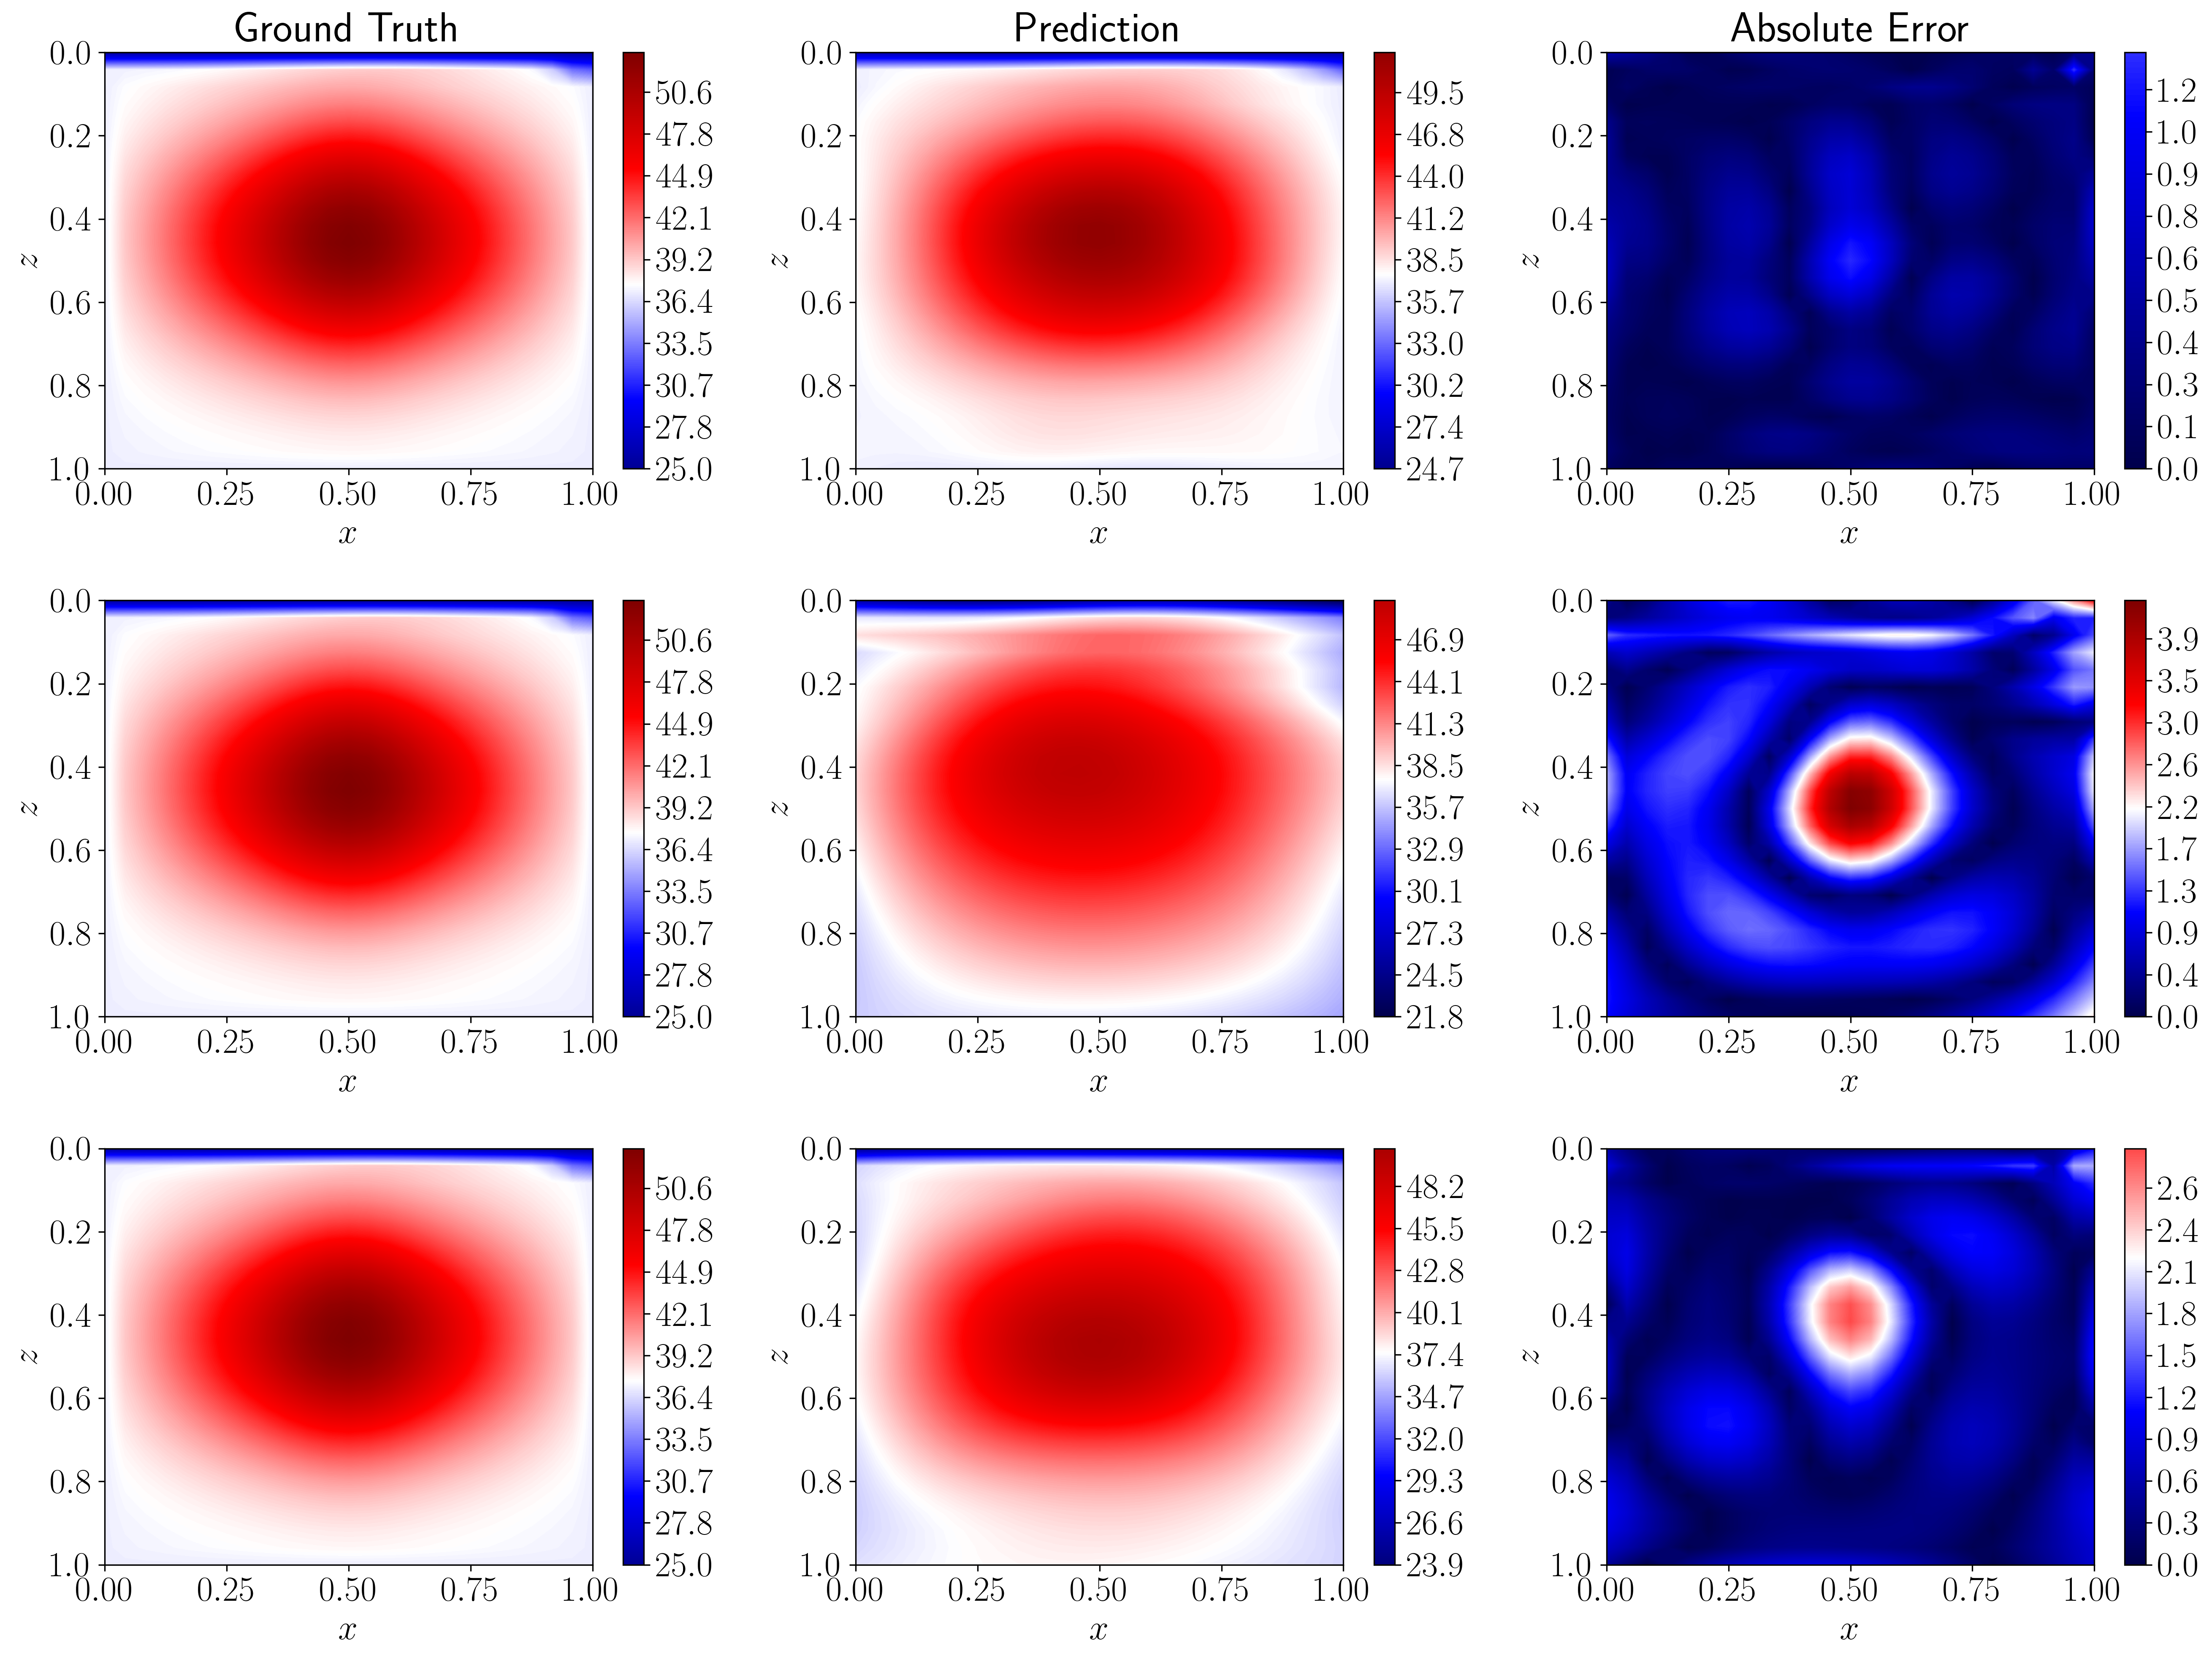

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Load data
S_pred_2 = np.load('Paper data/Updated source term/Generalization studies/Models/S_pred_Model_vanilla_4.npy')
S_test_2 = np.load('Paper data/Updated source term/Generalization studies/Models/S_test_4.npy')

S_pred_1 = np.load('Paper data/Updated source term/Generalization studies/Models/S_pred_Model2_4.npy')
S_test_1 = S_test_2  # Same ground truth

S_pred_fno = np.load('Paper data/Updated source term/Generalization studies/Models/S_pred_Model_FNO_4.npy')
S_test_fno = S_test_2  # Same ground truth

# Select time slice
time_slice = 124
S_pred_1_slice = S_pred_1[:, :, time_slice]
S_test_1_slice = S_test_1[:, :, time_slice]
error_1_slice = np.abs(S_pred_1_slice - S_test_1_slice)

S_pred_2_slice = S_pred_2[:, :, time_slice]
S_test_2_slice = S_test_2[:, :, time_slice]
error_2_slice = np.abs(S_pred_2_slice - S_test_2_slice)

S_pred_fno_slice = S_pred_fno[:, :, time_slice]
S_test_fno_slice = S_test_fno[:, :, time_slice]
error_fno_slice = np.abs(S_pred_fno_slice - S_test_fno_slice)

# Common color scales
vmin_data = min(S_test_1_slice.min(), S_pred_1_slice.min(), 
                S_pred_2_slice.min(), S_pred_fno_slice.min())
vmax_data = max(S_test_1_slice.max(), S_pred_1_slice.max(), 
                S_pred_2_slice.max(), S_pred_fno_slice.max())

max_error = max(np.max(error_1_slice), np.max(error_2_slice), np.max(error_fno_slice))

# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(18, 13.5))

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'computer modern sans serif'
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.dpi"] = 300

# --- Row 1: Vanilla Model ---
contour1 = axs[0, 0].contourf(XX[:, :, time_slice], YY[:, :, time_slice], S_test_1_slice, 1000, cmap='seismic', vmin=vmin_data, vmax=vmax_data)
axs[0, 0].set_title(r'Ground Truth')
axs[0, 0].set_xlabel(r'$x$')
axs[0, 0].set_ylabel(r'$z$')

contour2 = axs[0, 1].contourf(XX[:, :, time_slice], YY[:, :, time_slice], S_pred_1_slice, 1000, cmap='seismic', vmin=vmin_data, vmax=vmax_data)
axs[0, 1].set_title(r'Prediction')
axs[0, 1].set_xlabel(r'$x$')
axs[0, 1].set_ylabel(r'$z$')

contour3 = axs[0, 2].contourf(XX[:, :, time_slice], YY[:, :, time_slice], error_1_slice, 1000, cmap='seismic', vmin=0, vmax=max_error)
axs[0, 2].set_title(r'Absolute Error')
axs[0, 2].set_xlabel(r'$x$')
axs[0, 2].set_ylabel(r'$z$')

# --- Row 2: Model ResFouriONet ---
contour4 = axs[1, 0].contourf(XX[:, :, time_slice], YY[:, :, time_slice], S_test_2_slice, 1000, cmap='seismic', vmin=vmin_data, vmax=vmax_data)
axs[1, 0].set_xlabel(r'$x$')
axs[1, 0].set_ylabel(r'$z$')

contour5 = axs[1, 1].contourf(XX[:, :, time_slice], YY[:, :, time_slice], S_pred_2_slice, 1000, cmap='seismic', vmin=vmin_data, vmax=vmax_data)
axs[1, 1].set_xlabel(r'$x$')
axs[1, 1].set_ylabel(r'$z$')

contour6 = axs[1, 2].contourf(XX[:, :, time_slice], YY[:, :, time_slice], error_2_slice, 1000, cmap='seismic', vmin=0, vmax=max_error)
axs[1, 2].set_xlabel(r'$x$')
axs[1, 2].set_ylabel(r'$z$')

# --- Row 3: FNO Model ---
contour7 = axs[2, 0].contourf(XX[:, :, time_slice], YY[:, :, time_slice], S_test_fno_slice, 1000, cmap='seismic', vmin=vmin_data, vmax=vmax_data)
axs[2, 0].set_xlabel(r'$x$')
axs[2, 0].set_ylabel(r'$z$')

contour8 = axs[2, 1].contourf(XX[:, :, time_slice], YY[:, :, time_slice], S_pred_fno_slice, 1000, cmap='seismic', vmin=vmin_data, vmax=vmax_data)
axs[2, 1].set_xlabel(r'$x$')
axs[2, 1].set_ylabel(r'$z$')

contour9 = axs[2, 2].contourf(XX[:, :, time_slice], YY[:, :, time_slice], error_fno_slice, 1000, cmap='seismic', vmin=0, vmax=max_error)
axs[2, 2].set_xlabel(r'$x$')
axs[2, 2].set_ylabel(r'$z$')

# Reverse y-tick labels
for ax_row in axs:
    for ax in ax_row:
        y_ticks = ax.get_yticks()
        ax.set_yticks(y_ticks)
        ax.set_yticklabels([f'${tick:.1f}$' for tick in y_ticks[::-1]])

# Add colorbars with formatting
cbs = [
    plt.colorbar(contour1, ax=axs[0, 0]),
    plt.colorbar(contour2, ax=axs[0, 1]),
    plt.colorbar(contour3, ax=axs[0, 2]),
    plt.colorbar(contour4, ax=axs[1, 0]),
    plt.colorbar(contour5, ax=axs[1, 1]),
    plt.colorbar(contour6, ax=axs[1, 2]),
    plt.colorbar(contour7, ax=axs[2, 0]),
    plt.colorbar(contour8, ax=axs[2, 1]),
    plt.colorbar(contour9, ax=axs[2, 2]),
]

for cb in cbs:
    cb.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%.1f$'))

plt.tight_layout()
plt.show()


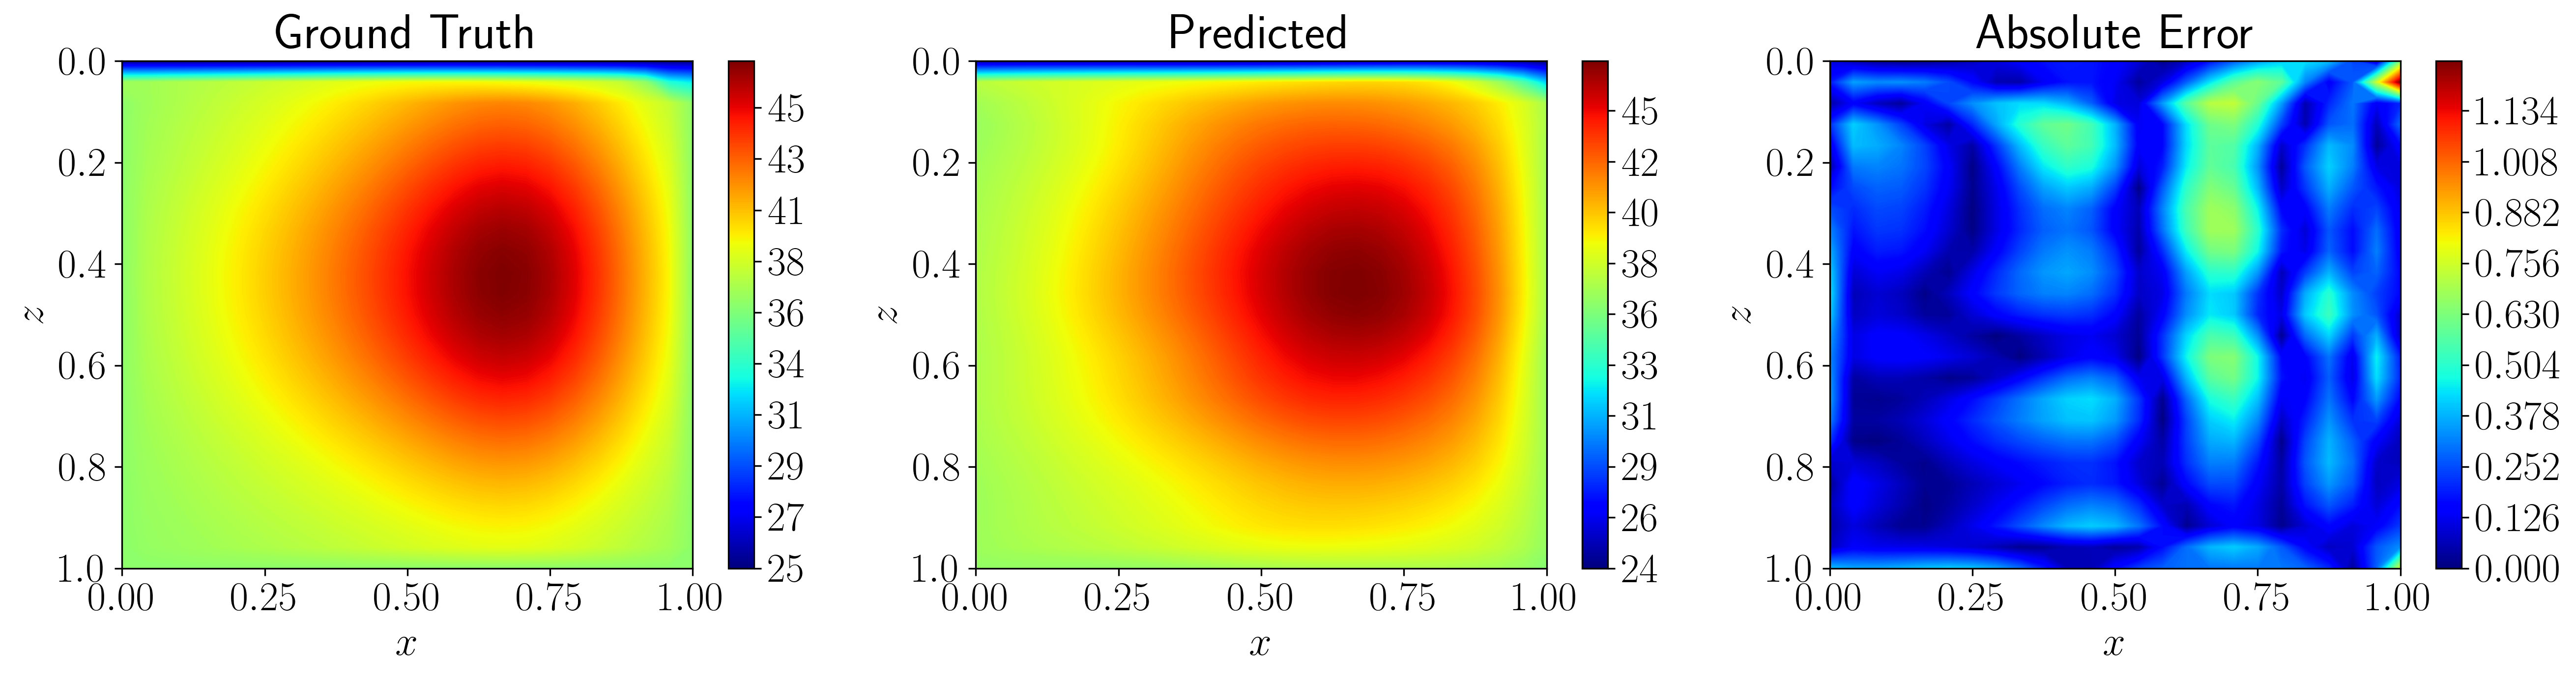

In [ ]:
import matplotlib.ticker as ticker

# S_pred_1 = np.load('Paper data/Generalization studies/Models/S_pred_Model_vanilla_1.npy')
# S_test_1 = np.load('Paper data/Generalization studies/Models/S_test_1.npy')

# S_pred_2 = np.load('Paper data/Generalization studies/Models/S_pred_Model2_1.npy')
# S_test_2 = np.load('Paper data/Generalization studies/Models/S_test_1.npy')

# Select a specific time slice (e.g., the middle time slice)
time_slice = 124
S_pred_slice = S_pred[:, :, time_slice]
S_test_slice = S_test[:, :, time_slice]

# Compute the absolute error between S_pred and S_test for the selected slice
error_slice = np.abs(S_pred_slice - S_test_slice)

vmin, vmax = min(S_pred_slice.min(), S_test_slice.min(), error_slice.min()), \
             max(S_pred_slice.max(), S_test_slice.max(), error_slice.max())

# Create subplots for side-by-side comparison
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'computer modern sans serif'  # Use serif font with LaTeX
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.dpi"] = 300

# Plot predicted contour
contour1 = axs[0].contourf(XX[:, :, time_slice], YY[:, :, time_slice], S_test_slice, 1000, cmap='jet')
axs[0].set_title(r'Ground Truth')
# plt.colorbar(contour1, ax=axs[0])
axs[0].set_xlabel(r'$x$')
axs[0].set_ylabel(r'$z$')

# Plot ground truth contour
contour2 = axs[1].contourf(XX[:, :, time_slice], YY[:, :, time_slice], S_pred_slice, 1000, cmap='jet')
axs[1].set_title(r'Predicted')
# plt.colorbar(contour2, ax=axs[1])
axs[1].set_xlabel(r'$x$')
axs[1].set_ylabel(r'$z$')

# Plot error contour
contour3 = axs[2].contourf(XX[:, :, time_slice], YY[:, :, time_slice], error_slice, 1000, cmap='jet')
axs[2].set_title(r'Absolute Error')
plt.colorbar(contour3, ax=axs[2])
axs[2].set_xlabel(r'$x$')
axs[2].set_ylabel(r'$z$')

for ax in axs:
    y_ticks = ax.get_yticks()  # Get current Y-axis ticks
    ax.set_yticks(y_ticks)  # Explicitly set the ticks first
    ax.set_yticklabels([f'${tick:.1f}$' for tick in y_ticks[::-1]])  # Reverse the tick labels only


# Add formatters to force float labels
for cbar in [plt.colorbar(contour1, ax=axs[0]), 
             plt.colorbar(contour2, ax=axs[1])]:
    cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%d$'))  # 2 decimal places

# Show the plots
plt.tight_layout()
plt.show()